<a href="https://colab.research.google.com/github/araldi/HS22_Big-Data-analysis-in-Biomedical-Research/blob/main/Week_09/17_Classification_on_Euler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Euler to run python code

This week, we will see how to run python script on Euler, which might be necessary when you are dealing with large datasets.

For this exercise, we will use data of brain cancer gene expression.

You can find the raw data on Kaggle: https://www.kaggle.com/datasets/brunogrisci/brain-cancer-gene-expression-cumida

## Prepare your environment

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import time
import random
import json
import os

# Set random seed
random.seed(2022)

## Download the data

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
ls /content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_exercises

'kaggle(1).json'   kaggleBrainTumor/   kaggle.json   kaggleTitanic/


In [4]:
cd /content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_exercises

/content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_exercises


In [5]:
envs = json.load(open("kaggle(1).json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [6]:
!kaggle datasets list -s 'gene expression'

ref                                                              title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
crawford/gene-expression                                         Gene expression dataset (Golub et al.)               1MB  2017-08-08 20:56:48          13202        248  0.8235294        
raghadalharbi/breast-cancer-gene-expression-profiles-metabric    Breast Cancer Gene Expression Profiles (METABRIC)    3MB  2020-05-26 20:08:07           3556         72  0.9411765        
brunogrisci/breast-cancer-gene-expression-cumida                 Breast cancer gene expression - CuMiDa              62MB  2020-02-01 10:51:48           1729         50  0.9705882        
brunogrisci/brain-cancer-gene-expression-cumida             

In [7]:
!mkdir kaggleBrainTumor

mkdir: cannot create directory ‘kaggleBrainTumor’: File exists


In [8]:
cd kaggleBrainTumor

/content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_exercises/kaggleBrainTumor


In [9]:
# download the titanic data into the directory you created for it
!kaggle datasets download -d brunogrisci/brain-cancer-gene-expression-cumida

brain-cancer-gene-expression-cumida.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
ls

brain-cancer-gene-expression-cumida.zip


In [11]:
!unzip brain-cancer-gene-expression-cumida.zip

Archive:  brain-cancer-gene-expression-cumida.zip
  inflating: Brain_GSE50161.csv      


In [12]:
ls

brain-cancer-gene-expression-cumida.zip  Brain_GSE50161.csv


In [13]:
mv Brain_GSE50161.csv /content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_376-1723-00L/week_09/Euler-Lucie/data/

In [14]:
cd /content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_376-1723-00L/week_09/Euler-Lucie/

/content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_376-1723-00L/week_09/Euler-Lucie


In [15]:
ls

code/  data/  Euler-practical_example_Lucie.gslides  output/


In [16]:
cd code

/content/gdrive/MyDrive/HS22_Big_Data_Analysis_in_Biomedical_Research_376-1723-00L/week_09/Euler-Lucie/code


In [17]:
# Declare paths
main_path = '../'
data_path = main_path + 'data/'
output_path = main_path + 'output/'

## Load the data

In [18]:
data = pd.read_csv(data_path + 'Brain_GSE50161.csv')

In [19]:
print(data.head())

   samples        type  1007_s_at   1053_at     117_at    121_at  1255_g_at  \
0      834  ependymoma  12.498150  7.604868   6.880934  9.027128   4.176175   
1      835  ependymoma  13.067436  7.998090   7.209076  9.723322   4.826126   
2      836  ependymoma  13.068179  8.573674   8.647684  9.613002   4.396581   
3      837  ependymoma  12.456040  9.098977   6.628784  8.517677   4.154847   
4      838  ependymoma  12.699958  8.800721  11.556188  9.166309   4.165891   

    1294_at   1316_at   1320_at  ...  AFFX-r2-Ec-bioD-3_at  \
0  7.224920  6.085942  6.835999  ...              9.979005   
1  7.539381  6.250962  8.012549  ...             11.924749   
2  7.813101  6.007746  7.178156  ...             12.154405   
3  8.361843  6.596064  6.347285  ...             11.969072   
4  7.923826  6.212754  6.866387  ...             11.411701   

   AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
0              9.926470            12.719785            12.777792   
1             

In [20]:
print('This dataset is of shape', data.shape)

This dataset is of shape (130, 54677)


In [21]:
print('There are', data['samples'].nunique(), 'unique samples in this dataset.')

There are 130 unique samples in this dataset.


In [22]:
print('There are', data['type'].nunique(), 'unique phenotypes/labels in this dataset.')
print('The phenotypes present are', data['type'].unique())

There are 5 unique phenotypes/labels in this dataset.
The phenotypes present are ['ependymoma' 'glioblastoma' 'medulloblastoma' 'normal'
 'pilocytic_astrocytoma']


## Aim of the analysis

We want to determine whether the 5 phenotypes can be predicted based on gene expression data.

Because this dataset includes the expression of 54'677 different genes, we will first write the code on Jupyter using a subset, before running the entire analysis on Euler.

## Subset the data

In [23]:
# select for the first 103 columns, note that this line will be commented out on Euler
data_analysis = data.iloc[:, :102]

# in order to use the same variable name in Jupyter and Euler, you can create a copy of data 
# note that this line will be uncommented on Euler
# data_analysis = data 

print('The dataset used for the analysis is of size', data_analysis.shape)

The dataset used for the analysis is of size (130, 102)


In [24]:
print('Number of NAs in the dataset')

# We will only print the columns in which data is missing
for col in data_analysis.columns:
  if data_analysis[col].isna().sum() != 0:
    print('There are', data_analysis[col].isna().sum(), 'in column', col)

print('For-loop done') # adding this line allows you to have an output even if no column has missing data

Number of NAs in the dataset
For-loop done


In [25]:
# Scale the data, excluding the first 2 columns (categorical)

cols = data_analysis.columns[~data_analysis.columns.isin(['samples', 'type'])]
data_analysis[cols] = preprocessing.scale(data_analysis[cols], axis=0)

## Dimensionality reduction

### t-SNE

For more information on the t-SNE implementation in Python, see the [sklearn documentation for t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


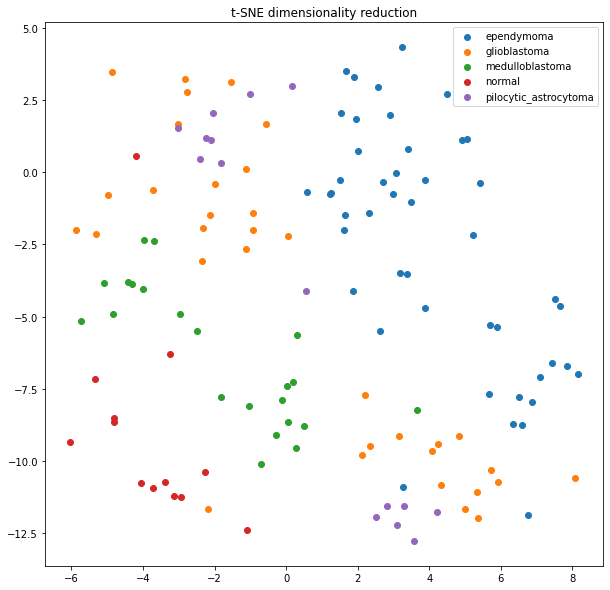

<Figure size 432x288 with 0 Axes>

In [26]:
twodproj = TSNE(n_components=2).fit_transform(data_analysis[cols])

plt.figure(figsize  = (10,10))

patient_phenotypes = data_analysis['type']
unique_labels = data_analysis['type'].unique()

for i in unique_labels:
    plt.scatter(twodproj[patient_phenotypes == i, 0], twodproj[patient_phenotypes == i, 1], label=i)
plt.title('t-SNE dimensionality reduction')
plt.legend()
plt.show()

# Don't forget to save your plot, especially when you work on Euler
plt.savefig(output_path + 'tSNE_plot.png')

## Class prediction

In [27]:
t0_gene = time.time()

# X is a dataframe with all the features/variables that we want to use for the classification
X = data_analysis[cols]
# y is a list containing the label to classify
y = data_analysis['type'].tolist()

'''
We first need to split out data into training and testing sets
We will fit the model on the training set and test it on the testing set
Note: we stratify the splitting according to the labels 
such that both the train and testing sets have a similar distribution
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2022, stratify = y)

In [28]:
# Specify the model to use and the hyperparameters
rf = ensemble.RandomForestClassifier(max_depth = 25, 
                                      criterion = "gini", 
                                      random_state = 2022)
# Fit the train data
rf = rf.fit(X_train, y_train)

In [29]:
# Predict the labels in the test set based on the model learnt on the train set
y_pred = rf.predict(X_test)

In [30]:
confusion_matrix(y_test, y_pred)

array([[9, 0, 0, 0, 0],
       [1, 6, 0, 0, 0],
       [0, 0, 4, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 2, 0, 0, 1]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x720 with 0 Axes>

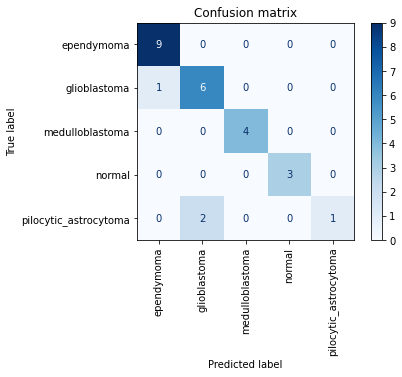

<Figure size 432x288 with 0 Axes>

In [31]:
# Visualise the prediction results in a confusion matrix

plt.figure(figsize = (10,10))
plot_confusion_matrix(rf, X_test, y_test, cmap = plt.cm.Blues)
plt.title('Confusion matrix')
plt.xticks(rotation=90)
plt.show()

# Don't forget to save your plot, especially when you work on Euler
plt.savefig(output_path + 'confusion_plot.png')

In [32]:
t1_gene = time.time()

total_gene = t1_gene - t0_gene
print('It took', round(total_gene, 3), 'seconds to run the prediction using the gene expression data.')

It took 0.666 seconds to run the prediction using the gene expression data.


In [33]:
# Output the classification report including multiple metrics

report = classification_report(y_test, y_pred, output_dict = True)
print(classification_report(y_test, y_pred))

# You can also save this report as a .csv file
report_dataframe = pd.DataFrame.from_dict(report)
report_dataframe.to_csv(output_path + 'class-prediction_report.csv')

                       precision    recall  f1-score   support

           ependymoma       0.90      1.00      0.95         9
         glioblastoma       0.75      0.86      0.80         7
      medulloblastoma       1.00      1.00      1.00         4
               normal       1.00      1.00      1.00         3
pilocytic_astrocytoma       1.00      0.33      0.50         3

             accuracy                           0.88        26
            macro avg       0.93      0.84      0.85        26
         weighted avg       0.90      0.88      0.87        26



### Class prediction including GridSearchCV

For more information about the implementation of grid search cross validation in python, you can refer to the corresponding sklearn page: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [34]:
t0_gene_CV = time.time()

# Declare the model to use, without specifying parameters (except from the seed here)
rf = ensemble.RandomForestClassifier(random_state = 2022)

# Decide the hyperparameters to be tested
min_samples_split = [2, 3, 4]                                      
max_depth = [5, 10, 25, 50, None]
criterion = ['gini','entropy']

# Combine all parameters in a dictionary
parameters_rf = dict(min_samples_split = min_samples_split,
                     criterion = criterion,
                     max_depth = max_depth)
print(parameters_rf)

{'min_samples_split': [2, 3, 4], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 25, 50, None]}


In [35]:
# Train random forest model with combinations of all hyperparameters above using GridSearchCV
# GridSearchCV will find the hyperparameters that will give you the best predictions in cross validation according to the scoring method chosen
gridrf = GridSearchCV(rf, parameters_rf, cv = 10, scoring = 'accuracy')
gridrf.fit(X_train, y_train)
print(gridrf.best_params_)
t1_gene_CV = time.time()

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 4}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x720 with 0 Axes>

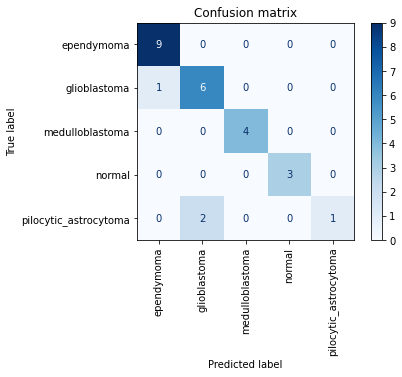

<Figure size 432x288 with 0 Axes>

In [36]:
# Predict the labels in the test set based on the model learnt on the train set
y_pred_CV = gridrf.predict(X_test)

# Visualise the prediction results in a confusion matrix

plt.figure(figsize = (10,10))
plot_confusion_matrix(gridrf, X_test, y_test, cmap = plt.cm.Blues)
plt.title('Confusion matrix')
plt.xticks(rotation = 90)
plt.show()

# Don't forget to save your plot, especially when you work on Euler
plt.savefig(output_path + 'confusion_plot_CV.png')

In [37]:
t1_gene_CV = time.time()

total_gene_CV = t1_gene_CV - t0_gene_CV
print('It took', round(total_gene_CV, 3), 'seconds to run the prediction using the gene expression data.')

It took 60.12 seconds to run the prediction using the gene expression data.


In [38]:
# Output the classification report including multiple metrics

report_CV = classification_report(y_test, y_pred_CV, output_dict = True)
print(classification_report(y_test, y_pred_CV))

# You can also save this report as a .csv file
report_dataframe_CV = pd.DataFrame.from_dict(report_CV)
report_dataframe_CV.to_csv(output_path + 'class-prediction-CV_report.csv')

                       precision    recall  f1-score   support

           ependymoma       0.90      1.00      0.95         9
         glioblastoma       0.75      0.86      0.80         7
      medulloblastoma       1.00      1.00      1.00         4
               normal       1.00      1.00      1.00         3
pilocytic_astrocytoma       1.00      0.33      0.50         3

             accuracy                           0.88        26
            macro avg       0.93      0.84      0.85        26
         weighted avg       0.90      0.88      0.87        26



## Exercises

It is now your turn to play around with this dataset, first using a subset and then the entire set of data on Euler.

### Part a

Run a principal component (PC) analysis (PCA).
 - Visualise the different types of tumor according to the first 2 PCs.
 - Do the group separate well? 
 - How much of the variance is explained from those 2 PCs? (Hint: have a look at the output in [the PCA scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))
 - How many components would you need to consider in order to capture 50% of the variance?
 
### Part b

We classified the different tumour types based on gene expression. This time, perform a similar classification but using the PCs instead of gene expression directly (choose the number of PCs that explain 50% of the variance). Don't forget that the data should be split in train and test sets, even to perform PCA. How is the model performing when using PCs compared to gene expression? How long does it take compared to the classification with the gene expression?

### Part a

### Part b